In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11786870051603384975
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14775656861898358792
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2112142015998551790
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15858476647
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4220506328159963189
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
]


In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import time
from data import *
from model3 import *
from utilities import *
from keras.callbacks import ModelCheckpoint, TensorBoard

train on ours dataset from scratch

Load our data. (size of $1024 \times 1024$, slice into 16 $256 \times 256$ sub-images with a stride of 128.)

In [7]:
trainfilename = "sq-our_256-train.p"
train_x, train_y, train_c = data_process(trainfilename, [["ours_1024/all/0image.jpg", "ours_1024/all/0dots.jpg"], 
                                                         ["ours_1024/all/1image.jpg", "ours_1024/all/1dots.jpg"], 
                                                         ["ours_1024/all/2image.jpg", "ours_1024/all/2dots.jpg"],
                                                         ["ours_1024/all/4image.jpg", "ours_1024/all/4dots.jpg"]],
                                         scale = 4, framesize = 256, slice_stride = 128, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-our_256-train.p
image data shape:  (4, 256, 256, 1)
ground truth data shape (4, 288, 288, 1)
count data shape (4, 1)


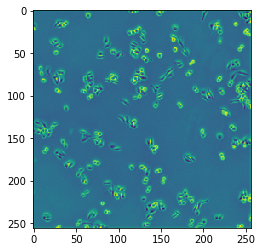

In [12]:
plot_map(train_x[0])

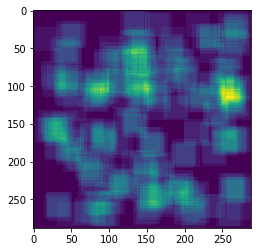

In [13]:
plot_map(train_y[0])

In [10]:
valfilename = "sq-our_256-val.p"
val_x, val_y, val_c = data_process(valfilename, [['ours_256/2image.jpg', 'ours_256/2dots.jpg']],
                                   scale = 1, framesize = 256, slice_stride = 128, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-our_256-val.p
image data shape:  (1, 256, 256, 1)
ground truth data shape (1, 288, 288, 1)
count data shape (1, 1)


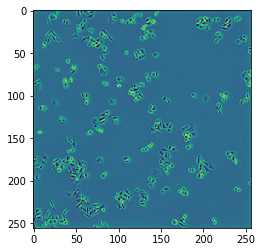

In [14]:
plot_map(val_x[0])

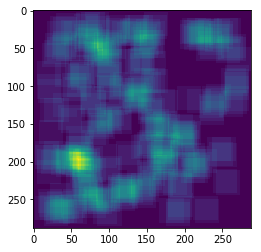

In [15]:
plot_map(val_y[0])

In [16]:
testfilename = "sq-our_256-test.p"
test_x, test_y, test_c = data_process(testfilename, [['ours_256/0image.jpg', 'ours_256/0dots.jpg']],
                                      scale = 1, framesize = 256, slice_stride = 128, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-our_256-test.p
image data shape:  (1, 256, 256, 1)
ground truth data shape (1, 288, 288, 1)
count data shape (1, 1)


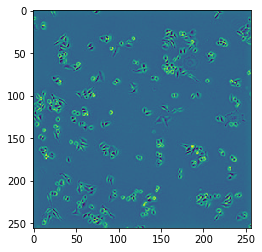

In [17]:
plot_map(test_x[0])

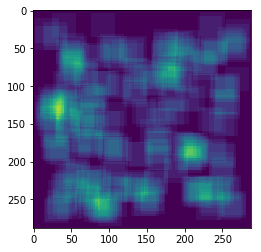

In [18]:
plot_map(test_y[0])

Train model.

In [19]:
TRAIN = True 
batch_size = 1
epochs = 100

In [20]:
%%capture output
model = build_model()
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-ours256-from-scratch.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-ours256-from-scratch-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

In [21]:
output.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_1 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_1[0][0]                    
__________

Load the best model.

In [22]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-ours256-from-scratch.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_6 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_2[0][0]                    
__________

Test.

In [24]:
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 21661.393292084336
Test MAE: 147.1781005859375


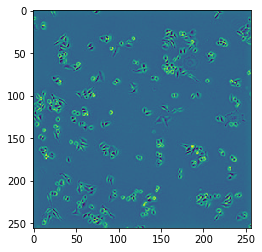

In [25]:
plot_map(test_x[0])

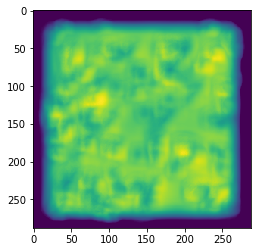

In [26]:
plot_map(pred[0])

In [27]:
tests

array([335.])

In [28]:
preds

array([482.17810059])

Load our data. (resize to $512 \times 512$, sliced into $256 \times 256$ sub-images with a stride of 64.)

In [3]:
trainfilename = "sq-our_512_all_sliced-train.p"
x, y, c = data_process(trainfilename, [["ours_1024/all/0image.jpg", "ours_1024/all/0dots.jpg"], 
                                       ["ours_1024/all/1image.jpg", "ours_1024/all/1dots.jpg"], 
                                       ["ours_1024/all/2image.jpg", "ours_1024/all/2dots.jpg"]],
                       scale = 2, framesize = 256, slice_stride = 64, kernel = "sq",
                       slicing = True, verbose = True)

reading from preprocessed data:  sq-our_512_all_sliced-train.p
image data shape:  (75, 256, 256, 1)
ground truth data shape (75, 288, 288, 1)
count data shape (75, 1)


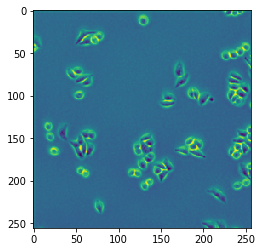

In [31]:
plot_map(x[0])

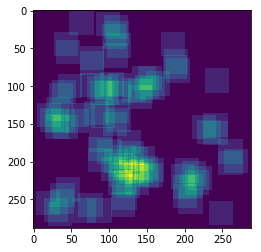

In [35]:
plot_map(y[0])

In [33]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
c = c[indices]

In [34]:
num_train = int(x.shape[0]*0.9)
train_x = x[:num_train]
train_y = y[:num_train]
train_c = c[:num_train]
val_x = x[num_train:]
val_y = y[num_train:]
val_c = c[num_train:]

In [4]:
trainfilename = "sq-our_512_all-4.p"
test_x, test_y, test_c = data_process(trainfilename, [["ours_1024/all/4image.jpg", "ours_1024/all/4dots.jpg"]],
                                      scale = 2, framesize = 256, slice_stride = 64, kernel = "sq",
                                      verbose = True)

reading from preprocessed data:  sq-our_512_all-4.p
image data shape:  (4, 256, 256, 1)
ground truth data shape (4, 288, 288, 1)
count data shape (4, 1)


In [38]:
TRAIN = True 
batch_size = 4
epochs = 100

In [ ]:
%%capture output
model = build_model()
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-ours512-from-scratch.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-ours512-from-scratch-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

In [41]:
output.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_4[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_15 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_4[0][0]                    
__________

In [5]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-ours512-from-scratch.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_1 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_1[0][0]                    
__________

In [6]:
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))
print("Test std:", np.mean(np.std(preds-tests)))

Test MSE: 243.20559366785164
Test MAE: 15.149759292602539
Test std: 3.7000523028809553


In [7]:
preds

array([84.7148819 , 79.92011261, 76.89059448, 70.87537384])

In [8]:
tests

array([101.,  89.,  96.,  87.])

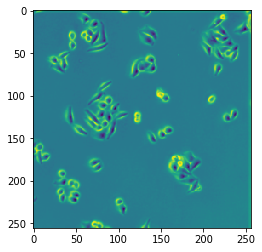

In [9]:
plot_map(test_x[1])

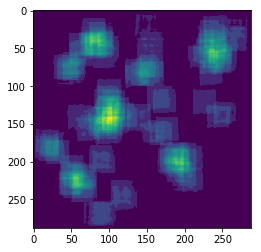

In [10]:
plot_map(pred[1])